<a href="https://colab.research.google.com/github/roma890/Drowsiness-detection/blob/main/drowsiness_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow matplotlib

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/My Drive/drowsy/drowsy dataset/FaceImages'

# Set the paths to the drowsy and non-drowsy folders
non_drowsy_path = os.path.join(dataset_path, 'non-drowsy')
drowsy_path = os.path.join(dataset_path, 'drowsy')

In [ ]:
# List of files in non-drowsy and drowsy directories

non_drowsy_images = os.listdir(non_drowsy_path)
drowsy_images = os.listdir(drowsy_path)

print(f"Number of non-drowsy images: {len(non_drowsy_images)}")
print(f"Number of drowsy images: {len(drowsy_images)}")

Number of non-drowsy images: 4560
Number of drowsy images: 4560


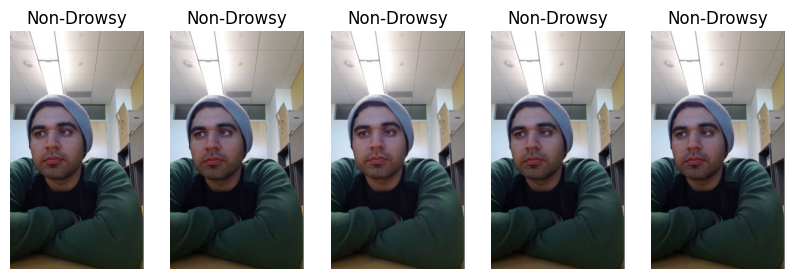

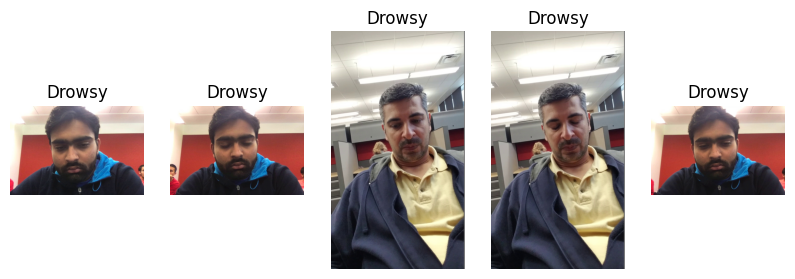

In [ ]:
# Function to display a set of images
def display_images(images_list, folder_path, label, num_images=5):
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = mpimg.imread(os.path.join(folder_path, images_list[i]))
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.show()

# Display a few non-drowsy images
display_images(non_drowsy_images, non_drowsy_path, 'Non-Drowsy')

# Display a few drowsy images
display_images(drowsy_images, drowsy_path, 'Drowsy')

In [ ]:
# Create output folders for resized images
output_non_drowsy_path = os.path.join(dataset_path, 'resized_non_drowsy')
output_drowsy_path = os.path.join(dataset_path, 'resized_drowsy')
os.makedirs(output_non_drowsy_path, exist_ok=True)
os.makedirs(output_drowsy_path, exist_ok=True)

In [ ]:
# Parameters for resizing
target_size = (224, 224)  # Resize images to 224x224

def resize_and_save_images(folder_path, output_folder, target_size):
    for filename in os.listdir(folder_path): #
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)  # Read the image
        if img is not None:  # Check if the image was loaded successfully
            resized_img = cv2.resize(img, target_size)  # Resize the image
            output_path = os.path.join(output_folder, filename) # save to new folder
            cv2.imwrite(output_path, resized_img)  # Save the resized image

# Resize and save images
resize_and_save_images(non_drowsy_path, output_non_drowsy_path, target_size)
resize_and_save_images(drowsy_path, output_drowsy_path, target_size)

print("Resizing complete! Resized images are saved in the new folders.")

In [ ]:
non_drowsy_count = os.listdir(output_non_drowsy_path)
drowsy_count = os.listdir(output_drowsy_path)
print(f"The resized non drowsy path has {len(non_drowsy_count)} images")
print(f"The resized drowsy path has {len(drowsy_count)} images")

The resized non drowsy path has 4560 images
The resized drowsy path has 4560 images


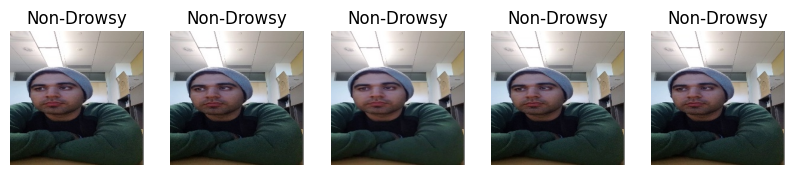

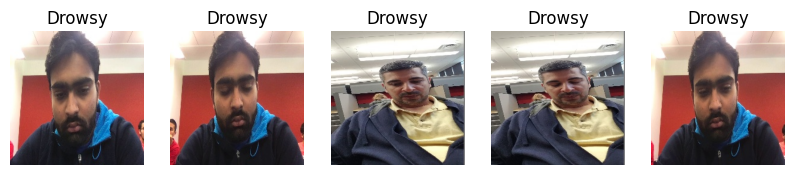

In [ ]:
#Verify every photo is the same size

# Display a few non-drowsy images from resized path
display_images(non_drowsy_images, output_non_drowsy_path, 'Non-Drowsy')

# Display a few drowsy images from resized path
display_images(drowsy_images, output_drowsy_path, 'Drowsy')

In [ ]:
resized_non_drowsy_folder = output_non_drowsy_path
resized_drowsy_folder = output_drowsy_path

In [ ]:
import tensorflow as tf


In [ ]:
# Function to load images and labels from the folders
# Function to load images and labels from the folders
def load_data(resized_non_drowsy_folder, resized_drowsy_folder):
    images = []
    labels = []

    # Load non-drowsy images
    for img_name in os.listdir(resized_non_drowsy_folder):
        img_path = os.path.join(resized_non_drowsy_folder, img_name)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img)
        images.append(img)
        labels.append(0)  # Label 0 for non-drowsy

    # Load drowsy images
    for img_name in os.listdir(resized_drowsy_folder):
        img_path = os.path.join(resized_drowsy_folder, img_name)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_image(img)
        images.append(img)
        labels.append(1)  # Label 1 for drowsy

    return images, labels

In [ ]:
!pip install torch torchvision


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision import models
import cv2
from PIL import Image
import torch.nn.functional as F

In [ ]:
class DrowsinessDataset(Dataset):
    def __init__(self, non_drowsy_folder, drowsy_folder, transform=None):
        self.non_drowsy_folder = non_drowsy_folder
        self.drowsy_folder = drowsy_folder
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load non-drowsy images
        for img_name in os.listdir(non_drowsy_folder):
            self.image_paths.append(os.path.join(non_drowsy_folder, img_name))
            self.labels.append(0)  # Label 0 for non-drowsy

        # Load drowsy images
        for img_name in os.listdir(drowsy_folder):
            self.image_paths.append(os.path.join(drowsy_folder, img_name))
            self.labels.append(1)  # Label 1 for drowsy

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Already resized, but ensuring consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
dataset = DrowsinessDataset(resized_non_drowsy_folder, resized_drowsy_folder, transform=transform)


In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10 # set num of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')


Epoch 1/10, Loss: 0.40756842551897643
Epoch 2/10, Loss: 0.2918178933511551
Epoch 3/10, Loss: 0.24907780196844487
Epoch 4/10, Loss: 0.21552151868955458
Epoch 5/10, Loss: 0.18871878315449545
Epoch 6/10, Loss: 0.16332169216158882
Epoch 7/10, Loss: 0.13079624885476118
Epoch 8/10, Loss: 0.11530922318547311
Epoch 9/10, Loss: 0.09473498341820569
Epoch 10/10, Loss: 0.07998879403059714


In [ ]:
model.eval() # evaluate the model
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')


Validation Loss: 0.3485696285876424, Accuracy: 88.96198830409357%


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')


Test Accuracy: 89.18128654970761%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
# display metrics for validation dataset
model.eval()
val_correct = 0
val_total = 0
val_labels_list = []
val_predictions_list = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_labels_list.extend(labels.numpy())
        val_predictions_list.extend(predicted.numpy())
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy = 100 * val_correct / val_total
val_precision = precision_score(val_labels_list, val_predictions_list)
val_recall = recall_score(val_labels_list, val_predictions_list)
val_f1 = f1_score(val_labels_list, val_predictions_list)

print(f'Validation Loss: {val_loss / len(val_loader) :.2f}, Accuracy: {val_accuracy: .2f} %')
print(f'Validation Precision: {val_precision: .2f} ')
print(f'Validation Recall: {val_recall: .2f} ')
print(f'Validation F1 Score: {val_f1: .2f} ')

Validation Loss: 0.35, Accuracy:  88.96 %
Validation Precision:  0.90 
Validation Recall:  0.87 
Validation F1 Score:  0.88 


In [ ]:

#display metrics For test dataset
model.eval()
test_correct = 0
test_total = 0
test_labels_list = []
test_predictions_list = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_labels_list.extend(labels.numpy())
        test_predictions_list.extend(predicted.numpy())
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
test_precision = precision_score(test_labels_list, test_predictions_list)
test_recall = recall_score(test_labels_list, test_predictions_list)
test_f1 = f1_score(test_labels_list, test_predictions_list)

print(f'Test Accuracy: {test_accuracy: .2f} %')
print(f'Test Precision: {test_precision: .2f}')
print(f'Test Recall: {test_recall: .2f}')
print(f'Test F1 Score: {test_f1: .2f}')


Test Accuracy:  89.18 %
Test Precision:  0.91
Test Recall:  0.86
Test F1 Score:  0.89


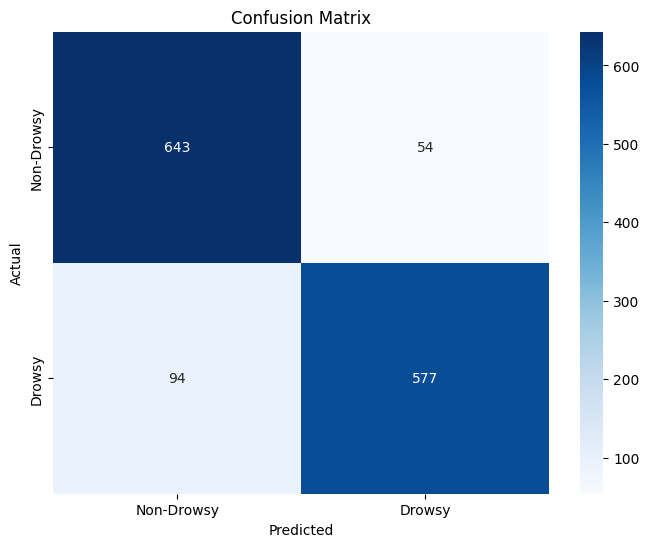

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels_list, test_predictions_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Drowsy', 'Drowsy'], yticklabels=['Non-Drowsy', 'Drowsy'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model.to(device)

# Function to get model probabilities
def get_probabilities(loader, model, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # Get probabilities for class 1
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

# Assuming test_loader is defined
y_probs, y_true = get_probabilities(test_loader, model, device)



Using device: cpu


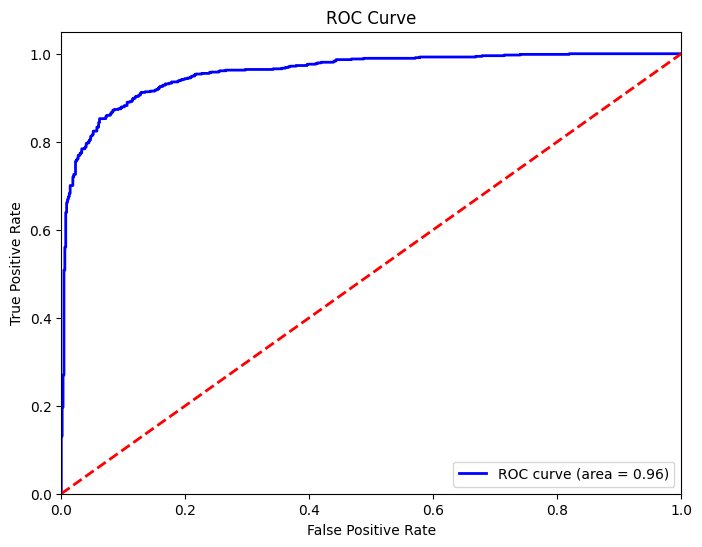

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


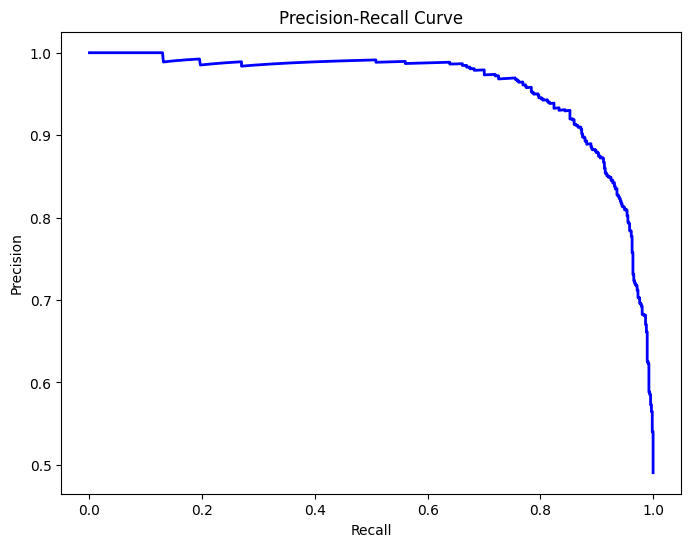

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
